## Tratamento Navios Tanque Completo

### Tratamentos Iniciais

In [130]:
import pm4py
import pandas as pd
from unidecode import unidecode
import string
import datetime
import numpy as np


In [131]:
# - Bases: ‘Relatório_NT_2023.xlsx’ e Relatório_NT_2022.xlsx’
# - Concatenar as duas bases

navioTanque1 = pd.read_excel("Arquivos\\Relatorio_NT_2022.xlsx")
navioTanque2 = pd.read_excel("Arquivos\\Relatorio_NT_2023.xlsx")

# Concatena os DataFrames
df_concatenado = pd.concat([navioTanque1, navioTanque2], ignore_index=True)

# Escreve o DataFrame concatenado em um novo arquivo Excel
df_concatenado.to_excel("Arquivos\\navios_concatenado.xlsx", index=False)
len(df_concatenado)

3285

Remover acentos e substituir caracteres especiais

In [132]:
df_concatenado = df_concatenado.map(lambda x: unidecode(str(x)) if isinstance(x, str) else x)

Padronizar formto de data e hora

In [133]:
lFormatDate = ['Data Prevista de Chegada', 'Data Prevista de Saída', 
'H.O.C.', 'Amarração','Início de Bombeio', 'Fim de Bombeio', 'Desamarração', 'H.O.S.', 'Início Primeira Amarração','Fim Primeira Amarração','Início Primeira Conexão','Fim Primeira Conexão',
'Início Primeiro Bombeio','Fim Último Bombeio','Início Última Desconexão','Fim Última Desconexão','Início Última Desamarração','Fim Última Desamarração']

for coluna in lFormatDate:
    df_concatenado[coluna] = pd.to_datetime(df_concatenado[coluna], dayfirst=True)

print(len(df_concatenado))

3285


Remover colunas que não são importantes

In [134]:
df_concatenado.drop(columns=["Classe do Navio","Rebocador","Hora Top","Alívio Crítico","Apuração Alívio Crítico","Volume Acumulado Perdas","Lifter"])

,Unidade Operativa,Instalação Naval,Navio,Volume Programado,Data Prevista de Chegada,Data Prevista de Saída,Viagem,Destino,H.O.C.,Amarração,...,Volume Retirado,Estaçao,Bsw (%),H2SOleo (mg/kg),H2SAgua (mg/l),Salinidade (mg/l),Temperatura (°C),Densidade 20°,Volume de Água Livre (m³),Responsável
0,UN-BS,PETROBRAS 67,FORTALEZA KNUTSEN,80000,2022-04-27 12:00:00,2022-04-28 09:30:00,423 TA,T.B.N.,2022-04-27 03:00:00,2022-04-27 09:04:00,...,81382.81,Proa,"0,2","0,2","0,5",102,"43,8","0,8757",Valor Medido,BSJ9
1,BUZIOS,PETROBRAS 77,EAGLE PAULINIA,80000,2022-07-25 12:00:00,2022-07-26 12:30:00,102 TA,T.B.N.,2022-07-25 12:00:00,2022-07-25 15:12:00,...,81704.09,Proa,"0,2","0,35",AD,32,"44,96","0,8795","36,56",DAGD
2,UN-BS,FPSO Cidade de Saquarema,DAN SABIA,60000,2022-05-11 12:00:00,2022-05-12 11:00:00,315 TA,T.B.N.,2022-05-11 08:30:00,2022-05-11 15:40:00,...,58883.00,Proa,"0,2",0,8,72,"48,92","0,8677",NaN,TVFE
3,UN-ES,FSO Cidade de Macae - MV15,TOVE KNUTSEN,80000,2022-05-11 14:00:00,2022-05-12 16:00:00,-,CARGA EQUINOR,2022-05-11 06:00:00,2022-05-11 15:00:00,...,79486.66,Proa,"1,96",0,AD,1112,"24,2","0,9072",AD,F8C9
4,UN-ES,FSO Cidade de Macae - MV15,TOVE KNUTSEN,80000,2022-05-11 14:00:00,2022-05-12 16:00:00,-,CARGA EQUINOR,2022-05-11 06:00:00,2022-05-11 15:00:00,...,79486.66,Proa,"1,96",0,AD,1112,"24,2","0,9072",AD,F8C9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,UN-BS,PETROBRAS 66,NT LISBOA,76000,2023-07-31 00:00:00,2023-08-01 04:06:00,PG043,CARGA PETROGAL,2023-07-30 00:01:00,2023-07-31 01:00:00,...,76781.44,Proa,"0,3","0,74","0,78",213,40,"0,8715",NaN,TVX3
3281,UN-ES,FSO Cidade de Macae - MV15,EAGLE CAMBE,151000,2023-07-31 03:01:00,2023-08-01 15:23:45,055 TA,T.B.N.,2023-07-30 20:00:00,2023-07-30 23:32:00,...,154121.00,-,"0,3",Valor Medido,Valor Medido,262,"22,3","0,8815",Valor Medido,TES1
3282,UN-ES,PETROBRAS 58,ANGRA DOS REIS,70000,2023-07-31 08:00:00,2023-08-01 16:00:00,429 TA,T.B.N.,2023-07-31 14:00:00,2023-07-31 19:20:00,...,71039.00,Proa,"0,4","0,34",NaN,453,"39,5","0,889","74,5",CSC4
3283,UN-BS,FPSO Cidade de Marica,EAGLE PAULINIA,155000,2023-07-31 08:00:00,2023-08-01 16:55:00,155 TA,T.B.N.,2023-07-31 09:00:00,2023-07-31 12:25:00,...,150823.66,Proa,"0,2",Valor Medido,Valor Medido,"25,7","50,23","0,8711",NaN,TVX3


Drop duplicates

In [135]:
df_concatenado = df_concatenado.drop_duplicates()

Criando a coluna ID

In [136]:
df_concatenado.loc[:,'ID'] = range(0, len(df_concatenado))
columns = ['ID'] + [colunas for colunas in df_concatenado.columns if colunas != 'ID']
df_concatenado = df_concatenado[columns]

Trocar "PETROBRAS" por "p-"

In [137]:
for index, linha in df_concatenado.iterrows():
    novaPalavra = df_concatenado.loc[index,"Instalação Naval"].replace("PETROBRAS","p-")
    df_concatenado.loc[index,"UEP"] = novaPalavra

 Retirando o espaço antes e no final dos nomes nas colunas UEP e Navio

In [138]:
df_concatenado.loc[:,"UEP"] = df_concatenado.loc[:,"UEP"].str.strip()
df_concatenado.loc[:,"Navio"] = df_concatenado.loc[:,"Navio"].str.strip()

Substituindo os valores de "H.O.C" onde a diferença for maior do que 48 horas (2 dias)


Tirar duplicatas dos casos que possuem mesmo HOC, Instalação Naval e Navio

In [139]:
df_concatenado = df_concatenado.drop_duplicates(subset=['Navio', 'Instalação Naval', 'H.O.C.'])

Criando colunas TNP

In [140]:
df_concatenado.reset_index()
for indice, linha in df_concatenado.iterrows():
    df_concatenado.at[indice, 'TNP_Amarracao_Conexao'] = (linha['Início Primeira Conexão'] - linha['Fim Primeira Amarração']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Bombeio_Desconexao'] = (linha['Início Última Desconexão'] - linha['Fim Último Bombeio']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_H.O.C_Amarracao'] = (linha['Amarração'] - linha['H.O.C.']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Conexao_Bombeio'] = (linha['Início Primeiro Bombeio'] - linha['Fim Primeira Conexão']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Desamarracao_HOS'] = (linha['H.O.S.'] - linha['Fim Última Desamarração']).total_seconds() / (60 * 60)
    df_concatenado.at[indice, 'TNP_Desconexao_Desamarracao'] = (linha['Início Última Desamarração'] - linha['Fim Última Desconexão']).total_seconds() / (60 * 60)

df_concatenado

,ID,Unidade Operativa,Instalação Naval,Navio,Volume Programado,Data Prevista de Chegada,Data Prevista de Saída,Viagem,Destino,H.O.C.,...,Apuração Alívio Crítico,Volume Acumulado Perdas,Lifter,UEP,TNP_Amarracao_Conexao,TNP_Bombeio_Desconexao,TNP_H.O.C_Amarracao,TNP_Conexao_Bombeio,TNP_Desamarracao_HOS,TNP_Desconexao_Desamarracao
0,0,UN-BS,PETROBRAS 67,FORTALEZA KNUTSEN,80000,2022-04-27 12:00:00,2022-04-28 09:30:00,423 TA,T.B.N.,2022-04-27 03:00:00,...,NaN,0,NaN,p- 67,0.083333,1.500000,6.066667,1.816667,0.166667,0.083333
1,1,BUZIOS,PETROBRAS 77,EAGLE PAULINIA,80000,2022-07-25 12:00:00,2022-07-26 12:30:00,102 TA,T.B.N.,2022-07-25 12:00:00,...,NaN,0,NaN,p- 77,0.300000,1.800000,3.200000,2.050000,0.333333,0.266667
2,2,UN-BS,FPSO Cidade de Saquarema,DAN SABIA,60000,2022-05-11 12:00:00,2022-05-12 11:00:00,315 TA,T.B.N.,2022-05-11 08:30:00,...,NaN,0,NaN,FPSO Cidade de Saquarema,0.250000,1.933333,7.166667,2.500000,1.166667,0.166667
3,3,UN-ES,FSO Cidade de Macae - MV15,TOVE KNUTSEN,80000,2022-05-11 14:00:00,2022-05-12 16:00:00,-,CARGA EQUINOR,2022-05-11 06:00:00,...,NaN,0,NaN,FSO Cidade de Macae - MV15,0.016667,3.000000,9.000000,1.133333,0.200000,0.100000
5,4,UN-BS,FPSO Cidade de Ilhabela,EAGLE CAMPOS,79100,2022-05-11 00:00:00,2022-05-12 12:18:00,SH121,CARGA SHELL,2022-05-11 06:00:00,...,NaN,0,NaN,FPSO Cidade de Ilhabela,0.250000,2.583333,9.933333,1.733333,0.150000,0.033333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3280,3231,UN-BS,PETROBRAS 66,NT LISBOA,76000,2023-07-31 00:00:00,2023-08-01 04:06:00,PG043,CARGA PETROGAL,2023-07-30 00:01:00,...,NaN,0,NaN,p- 66,0.016667,1.300000,24.983333,3.000000,0.500000,0.016667
3281,3232,UN-ES,FSO Cidade de Macae - MV15,EAGLE CAMBE,151000,2023-07-31 03:01:00,2023-08-01 15:23:45,055 TA,T.B.N.,2023-07-30 20:00:00,...,NaN,0,NaN,FSO Cidade de Macae - MV15,0.200000,2.383333,3.533333,1.333333,0.333333,0.216667
3282,3233,UN-ES,PETROBRAS 58,ANGRA DOS REIS,70000,2023-07-31 08:00:00,2023-08-01 16:00:00,429 TA,T.B.N.,2023-07-31 14:00:00,...,NaN,0,NaN,p- 58,0.166667,0.666667,5.333333,1.583333,0.166667,0.166667
3283,3234,UN-BS,FPSO Cidade de Marica,EAGLE PAULINIA,155000,2023-07-31 08:00:00,2023-08-01 16:55:00,155 TA,T.B.N.,2023-07-31 09:00:00,...,NaN,0,NaN,FPSO Cidade de Marica,0.166667,0.833333,3.416667,2.000000,0.116667,0.283333


In [141]:
diferenca_horas = df_concatenado.loc[:, 'TNP_H.O.C_Amarracao']

df_concatenado.loc[diferenca_horas >= 48, 'H.O.C.'] = df_concatenado['Data Prevista de Chegada']

In [142]:
df_concatenado[['TNP_Amarracao_Conexao','TNP_Bombeio_Desconexao','TNP_H.O.C_Amarracao','TNP_Conexao_Bombeio','TNP_Desamarracao_HOS','TNP_Desconexao_Desamarracao']].describe().round(2)

,TNP_Amarracao_Conexao,TNP_Bombeio_Desconexao,TNP_H.O.C_Amarracao,TNP_Conexao_Bombeio,TNP_Desamarracao_HOS,TNP_Desconexao_Desamarracao
count,3217.00,3217.00,3217.00,3217.00,3217.00,3217.00
mean,0.43,1.87,9.76,2.47,0.80,0.24
std,1.87,2.03,12.27,3.67,3.16,0.44
min,-0.02,-5.12,0.02,0.02,0.02,0.02
25%,0.07,1.20,3.50,1.60,0.25,0.03
50%,0.20,1.52,5.00,1.98,0.33,0.17
75%,0.33,2.00,10.67,2.53,0.50,0.30
max,45.35,54.50,146.42,159.07,120.25,17.50


Removendo colunas com valores negativos

In [143]:
remover = df_concatenado.loc[(df_concatenado['TNP_Amarracao_Conexao'] < 0) |
                (df_concatenado['TNP_Bombeio_Desconexao'] < 0) |
                (df_concatenado['TNP_H.O.C_Amarracao'] < 0) |
                (df_concatenado['TNP_Conexao_Bombeio'] < 0) |
                (df_concatenado['TNP_Desconexao_Desamarracao'] < 0) |
                (df_concatenado['TNP_Desamarracao_HOS'] < 0)].index
# Remove as linhas com os índices identificados
df_concatenado = df_concatenado.drop(remover)
# Se desejar redefinir o índice após a remoção das linhas
df_concatenado = df_concatenado.reset_index(drop=True)
len(remover)

2

## ALTERANDO O FORMATO DA BASE

In [144]:
# Selecionar apenas as colunas necessárias para alteração no formato do dataframe
nt_colunas = ['ID', 'H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração', 'Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desamarração', 'Fim Última Desamarração', 'H.O.S.']
# Selecionar e definir as colunas que serão alteradas
colunas_alteradas = ['H.O.C.', 'Início Primeira Amarração', 'Fim Primeira Amarração','Início Primeira Conexão', 'Fim Primeira Conexão', 'Início Primeiro Bombeio','Fim Último Bombeio', 'Início Última Desconexão', 'Fim Última Desconexão','Início Última Desconexão', 'Fim Última Desconexão', 'Início Última Desamarração','Fim Última Desamarração', 'H.O.S.']
# Usar o método melt para transformar as colunas em registros
df_transformado = pd.melt(df_concatenado[nt_colunas], id_vars=['ID'], value_vars=colunas_alteradas, var_name='Ocorrência', value_name='Data')
# Selecionar apenas as colunas necessárias para a junção
colunas_restauradas = ['ID', 'Unidade Operativa', 'UEP', 'Navio', 'Volume Programado','Volume Retirado', 'Viagem', 'Destino', 'Data Prevista de Chegada','Data Prevista de Saída']
# Realizar a junção dos DataFrames usando a coluna 'ID' como chave
df_final = pd.merge(df_concatenado[colunas_restauradas], df_transformado, on='ID', how='right')

Ordenar o DataFrame final por 'ID' e 'Data'

In [145]:
df_final = df_final.sort_values(by=['ID', 'Data'])

Adicionar as colunas 'Início' e 'Término' com base nas datas da ocorrência e da próxima ocorrência para o mesmo ID

In [146]:
df_final['Início'] = df_final['Data']
# Obter o valor da próxima linha na coluna "Início"
df_final['Término'] = df_final['Início'].shift(-1)

Excluir as colunas com “Ocorrência” = ”Fim”

In [147]:
# Filtrar as linhas em que a "Ocorrência" contém a palavra "Fim" e obter seus índices
indices_para_remover = df_final[df_final['Ocorrência'].str.contains('Fim')].index
# Remover as linhas correspondentes aos índices obtidos
df_final.drop(indices_para_remover, inplace=True)

Renomear as colunas 

In [148]:
# Retirar a palavra Início da ocorrência
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Início ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Última ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeiro ', '')
df_final['Ocorrência'] = df_final['Ocorrência'].str.replace('Primeira ', '')

Remover a coluna ‘Data’

In [149]:
# Removendo as colunas, inplace é pra não precisar reatribuir e axis 1 serve pra dizer que se trata de uma coluna
df_final.drop(['Data'],inplace=True, axis=1)

## BASE INTERRUPÇÕES

In [150]:
dfInt = pd.read_excel("Arquivos\\eventos_operacoes_interrupcoes2.xlsx")

Filtrar apenas para quem teve interrupção 

In [151]:
# Filtrar apenas as linhas em que 'Duração Interrupção' é maior que zero e reatribuir ao DataFrame dfInt
dfInt = dfInt[dfInt['Duração Interrupção'] > 0]

Retirar acento e ç

In [152]:
dfInt = dfInt.apply(lambda x: x.map(lambda y: unidecode(str(y)) if isinstance(y, str) else y))

Criar a coluna UEP na posição 2 

In [153]:
# Adicionando a coluna UEP 
dfInt.insert(2, 'UEP', dfInt['INNA_SG_INSTALACAO_NAVAL'].str.replace('PETROBRAS', 'P-', regex=True))

Alterar os nomes das categorias

In [154]:
# Faz um dicionário com os nomes a serem mudados na UEP
trocaNomes = {
    'FPBAR': 'FPSO Almirante Barroso',
    'FPCGZ': 'FPSO Campos dos Goytacases MV29',
    'CAPX': 'FPSO Capixaba',
    'FPCRC': 'FPSO CARIOCA MV30',
    'FPNIT': 'FPSO Cid. Niteroi MV18',
    'CDAN': 'FPSO Cidade de Anchieta',
    'FPCAR': 'FPSO Cidade de Angra Reis MV22',
    'FPCIB': 'FPSO Cidade de Ilhabela',
    'FPCMB': 'FPSO Cidade de Mangaratiba MV24',
    'FPCIG': 'FPSO Cidade de Itaguai MV26',
    'FPCMC': 'FPSO Cidade de Marica',
    'FPCPY': 'FPSO Cidade de Paraty',
    'FPCST': 'FPSO Cidade de Santos MV20',
    'FPCSQ': 'FPSO Cidade de Saquarema',
    'FPCSP': 'FPSO Cidade Sao Paulo MV23',
    'FPGNB': 'FPSO Guanabara - MV31',
    'FPPLB': 'FPSO Pioneiro de Libra',
    'FSME': 'FSO Cidade de Macae - MV15'
}

# Faz a troca dos nomes da UEP utilizando o replace
dfInt['UEP'] = dfInt['UEP'].replace(trocaNomes)

Renomear as colunas para ficar com a mesma nomenclatura que a base NT 

In [155]:
# Definindo o dicionário para renomear as colunas
nomeColunas = {
    'OPOF_CD_VIAGEM': 'Viagem',
    'OPOF_NM_NAVIO': 'Navio',
    'OPOF_NM_DESTINO': 'Destino',
    'EOOF_IN_TIPO': 'TIPO_INTERRUPCAO',
    'Duração Interrupção': 'DURACAO_INTERRUPCAO',
    'EOOF_DT_REALIZADA': 'INICIO_INTERRUPCAO',
    'EOOF_DT_FIM': 'FIM_INTERRUPCAO',
    'OPOF_DT_ENTRADA_PREVISTA': 'Data Prevista de Chegada',
    'OPOF_DT_SAIDA_PREVISTA': 'Data Prevista de Saída'
}

# Renomeando as colunas conforme o dicionário 
dfInt.rename(columns=nomeColunas, inplace=True)

Retirar o espaço do final dos nomes 

In [156]:
# Remover espaços em branco antes e depois dos nomes nas colunas UEP e Navio
dfInt['UEP'] = dfInt['UEP'].str.strip()
dfInt['Navio'] = dfInt['Navio'].str.strip()

 Selecionar apenas as colunas que interessam

In [157]:
# Selecionar apenas as colunas necessárias do DataFrame dfInt
colunasSel = dfInt[['UEP', 'Viagem', 'Navio', 'Destino', 'TIPO_INTERRUPCAO', 'DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO', 'Data Prevista de Chegada', 'Data Prevista de Saída']]

INCLUSÃO DA INTERRUPÇÃO NA BASE NOVA NT

In [158]:
# Junção das bases de interrupções e NT
dfUni = pd.merge(df_final, colunasSel, on=['UEP', 'Viagem', 'Navio', 'Destino', 'Data Prevista de Chegada', 'Data Prevista de Saída'], how='left')
dfUni

,ID,Unidade Operativa,UEP,Navio,Volume Programado,Volume Retirado,Viagem,Destino,Data Prevista de Chegada,Data Prevista de Saída,Ocorrência,Início,Término,TIPO_INTERRUPCAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
0,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,NaN,NaN,NaT,NaT
1,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,NaN,NaN,NaT,NaT
2,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Conexão,2022-04-27 09:40:00,2022-04-27 10:11:00,NaN,NaN,NaT,NaT
3,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Bombeio,2022-04-27 12:00:00,2022-04-28 07:00:00,NaN,NaN,NaT,NaT
4,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Desconexão,2022-04-28 08:30:00,2022-04-28 08:55:00,NaN,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22619,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Conexão,2023-07-31 16:30:00,2023-07-31 17:48:00,NaN,NaN,NaT,NaT
22620,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Bombeio,2023-07-31 19:06:00,2023-08-01 12:42:00,NaN,NaN,NaT,NaT
22621,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desconexão,2023-08-01 14:48:00,2023-08-01 15:36:00,NaN,NaN,NaT,NaT
22622,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,NaN,NaN,NaT,NaT


Restringir as características de interrupção apenas aos bombeios

In [159]:
# Substituir valor da coluna 'TIPO_INTERRUPCAO' por 'Interrupção Bombeio' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'B005', caso contrário, substituir por ''
condicao_1 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'B005')
dfUni.loc[condicao_1, 'TIPO_INTERRUPCAO'] = 'Interrupção Bombeio'
dfUni.loc[~condicao_1, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'DURACAO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'DURACAO_INTERRUPCAO' > 0
condicao_2 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['DURACAO_INTERRUPCAO'] > 0)
dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO'] = dfUni.loc[condicao_2, 'DURACAO_INTERRUPCAO']
dfUni.loc[~condicao_2, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'INICIO_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_3 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO'] = dfUni.loc[condicao_3, 'INICIO_INTERRUPCAO']
dfUni.loc[~condicao_3, 'TIPO_INTERRUPCAO'] = ''

# Manter valor da coluna 'FIM_INTERRUPCAO' onde 'Ocorrência' contém 'Bombeio' e 'TIPO_INTERRUPCAO' = 'Interrupção Bombeio'
condicao_4 = (dfUni['Ocorrência'].str.contains('Bombeio')) & (dfUni['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
dfUni.loc[condicao_4, 'FIM_INTERRUPCAO'] = dfUni.loc[condicao_4, 'FIM_INTERRUPCAO']
dfUni.loc[~condicao_4, 'TIPO_INTERRUPCAO'] = ''


Duplicar as linhas em que acontece as interrupções 

In [160]:
indices_para_remover = []
# da ruim
# df_filtered = dfUni[dfUni['TIPO_INTERRUPCAO'].notna()]
# df_resultado = pd.concat([dfUni, df_filtered], ignore_index=True)
for i, row in dfUni.iterrows():
    if i < len(dfUni) - 2:
        linha_atual = dfUni.iloc[i]
        linha_seguinte = dfUni.iloc[i+1]
        linha_seguinte_seguinte = dfUni.iloc[i+2]
        if ((linha_atual["ID"] == linha_seguinte["ID"]) & (linha_atual['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_seguinte['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (linha_atual['DURACAO_INTERRUPCAO'] != linha_seguinte['DURACAO_INTERRUPCAO'])):
             indices_para_remover.append(i+2)
df_resultado = dfUni.drop(indices_para_remover)
df_resultado

,ID,Unidade Operativa,UEP,Navio,Volume Programado,Volume Retirado,Viagem,Destino,Data Prevista de Chegada,Data Prevista de Saída,Ocorrência,Início,Término,TIPO_INTERRUPCAO,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
0,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,H.O.C.,2022-04-27 03:00:00,2022-04-27 09:04:00,,NaN,NaT,NaT
1,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Amarração,2022-04-27 09:04:00,2022-04-27 09:35:00,,NaN,NaT,NaT
2,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Conexão,2022-04-27 09:40:00,2022-04-27 10:11:00,,NaN,NaT,NaT
3,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Bombeio,2022-04-27 12:00:00,2022-04-28 07:00:00,,NaN,NaT,NaT
4,0,UN-BS,p- 67,FORTALEZA KNUTSEN,80000,81382.81,423 TA,T.B.N.,2022-04-27 12:00:00,2022-04-28 09:30:00,Desconexão,2022-04-28 08:30:00,2022-04-28 08:55:00,,NaN,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22619,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Conexão,2023-07-31 16:30:00,2023-07-31 17:48:00,,NaN,NaT,NaT
22620,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Bombeio,2023-07-31 19:06:00,2023-08-01 12:42:00,,NaN,NaT,NaT
22621,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desconexão,2023-08-01 14:48:00,2023-08-01 15:36:00,,NaN,NaT,NaT
22622,3235,UN-BUZ,p- 76,ELKA LEBLON,80000,81372.15,402 TA,T.B.N.,2023-07-31 13:00:00,2023-08-01 18:00:00,Desamarração,2023-08-01 15:37:00,2023-08-01 16:12:00,,NaN,NaT,NaT


Ordenar por ID e Início 

In [161]:
# Ordenar por ID e início
df_resultado.sort_values(by=['ID', 'Início','INICIO_INTERRUPCAO'], inplace=True)

Percebemos que em alguns casos (Ex: ID 394) o início da interrupção acontece antes do início do bombeio. Nesses casos, substituir valor de início da interrupção pelo valor de início do bombeio (‘Início’). O mesmo acontece para as datas de fim, se o fim da interrupção for depois do fim do bombeio, substituir fim da interrupção com o valor de fim do bombeio

In [162]:

# Verificar se TIPO_INTERRUPCAO está vazio e substituir os valores das outras colunas
condicao = df_resultado['TIPO_INTERRUPCAO'] == ''
df_resultado.loc[condicao, ['DURACAO_INTERRUPCAO', 'INICIO_INTERRUPCAO', 'FIM_INTERRUPCAO']] = np.nan

# Substituir o início da interrupção pelo valor de início do bombeio onde necessário
df_resultado.loc[df_resultado['INICIO_INTERRUPCAO'] < df_resultado['Início'], 'INICIO_INTERRUPCAO'] = df_resultado['Início']

# Substituir o fim da interrupção pelo valor de fim do bombeio onde necessário
df_resultado.loc[df_resultado['FIM_INTERRUPCAO'] > df_resultado['Término'], 'FIM_INTERRUPCAO'] = df_resultado['Término']

Alterar as datas de Término da primeira interrupção e Início da segunda interrupção dentro de um mesmo ID

In [163]:
# Verificar se TIPO_INTERRUPCAO de linhas consecutivas são iguais a "Interrupção Bombeio"
condicao_1 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio')
# Verificar se DURACAO_INTERRUPCAO de linhas consecutivas são diferentes
condicao_2 = (df_resultado['TIPO_INTERRUPCAO'].shift() == 'Interrupção Bombeio') & (df_resultado['TIPO_INTERRUPCAO'] == 'Interrupção Bombeio') & (df_resultado['DURACAO_INTERRUPCAO'].shift() != df_resultado['DURACAO_INTERRUPCAO'])
# Atualizar as datas conforme as condições especificadas
df_resultado.loc[condicao_1, 'Término'] = df_resultado['INICIO_INTERRUPCAO'].shift(-1)
df_resultado.loc[condicao_1, 'Início'] = df_resultado['FIM_INTERRUPCAO']
df_resultado.loc[condicao_2, 'Início'] = df_resultado['FIM_INTERRUPCAO']

Retirar os casos com bombeio instantâneo

In [164]:
for indice,linha in df_resultado.iterrows():
    if linha['Início'] == linha['Término']:
       df_resultado.drop(index=indice)

Para a ocorrência H.O.S. trocar os términos que estão vazios pelos inícios, pois o H.O.S. é sempre instantâneo.


In [165]:
for index,linha in df_resultado.iterrows():
    if linha['Ocorrência'] == "H.O.S.":
        if type(df_resultado.loc[index,'Término']) == pd._libs.tslibs.nattype.NaTType:
            df_resultado.loc[index,'Término'] = df_resultado.loc[index,"Início"]
df_resultado.to_excel('Arquivos\\base_final.xlsx')

In [166]:
#Base final
df_resultado.describe().round(2)

,ID,Volume Programado,Volume Retirado,Data Prevista de Chegada,Data Prevista de Saída,Início,Término,DURACAO_INTERRUPCAO,INICIO_INTERRUPCAO,FIM_INTERRUPCAO
count,22607.00,22607.00,22607.00,22607,22607,22607,22593,163.00,163,163
mean,1619.54,80795.67,80321.55,2022-10-16 15:14:19.816959232,2022-10-18 01:22:29.611889920,2022-10-17 08:37:46.379439872,2022-10-17 06:42:33.724604928,3.97,2022-09-27 15:39:00.368098304,2022-09-27 19:33:52.638036992
min,0.00,2000.00,1990.10,2022-01-01 00:01:00,2022-01-01 23:30:00,2022-01-01 00:01:00,2022-01-01 00:01:00,0.02,2022-01-05 22:50:00,2022-01-06 00:00:00
25%,808.00,70000.00,70094.09,2022-05-24 06:00:00,2022-05-25 19:00:00,2022-05-25 06:00:00,2022-05-25 03:35:00,0.37,2022-04-24 15:06:00,2022-04-24 19:48:00
50%,1622.00,79500.00,78952.91,2022-10-14 12:00:00,2022-10-16 06:00:00,2022-10-15 06:52:00,2022-10-15 06:00:00,0.92,2022-09-29 00:26:00,2022-09-29 00:45:00
75%,2429.00,87000.00,86001.94,2023-03-09 12:00:00,2023-03-10 18:00:00,2023-03-09 20:06:00,2023-03-09 17:24:00,2.21,2023-02-18 13:19:00,2023-02-18 22:50:00
max,3235.00,166000.00,170507.00,2023-07-31 13:00:00,2023-08-01 18:00:00,2023-08-01 18:00:00,2023-08-01 18:00:00,92.57,2023-07-27 00:56:00,2023-07-27 01:30:00
std,934.51,30098.40,30294.74,NaN,NaN,NaN,NaN,10.90,NaN,NaN


Teste de gráfico

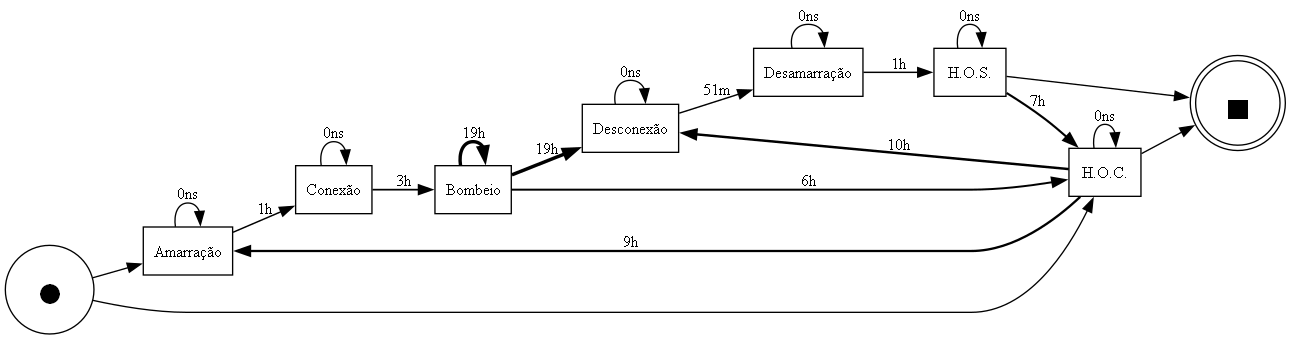

In [167]:
import pm4py

if __name__ == "__main__":
    #Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('Arquivos\\base_final.xlsx')
    log['ID'] = log['ID'].astype(str)
    performance_dfg, start_activities, end_activities = pm4py.discover_performance_dfg(log, case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    pm4py.view_performance_dfg(performance_dfg, start_activities, end_activities)

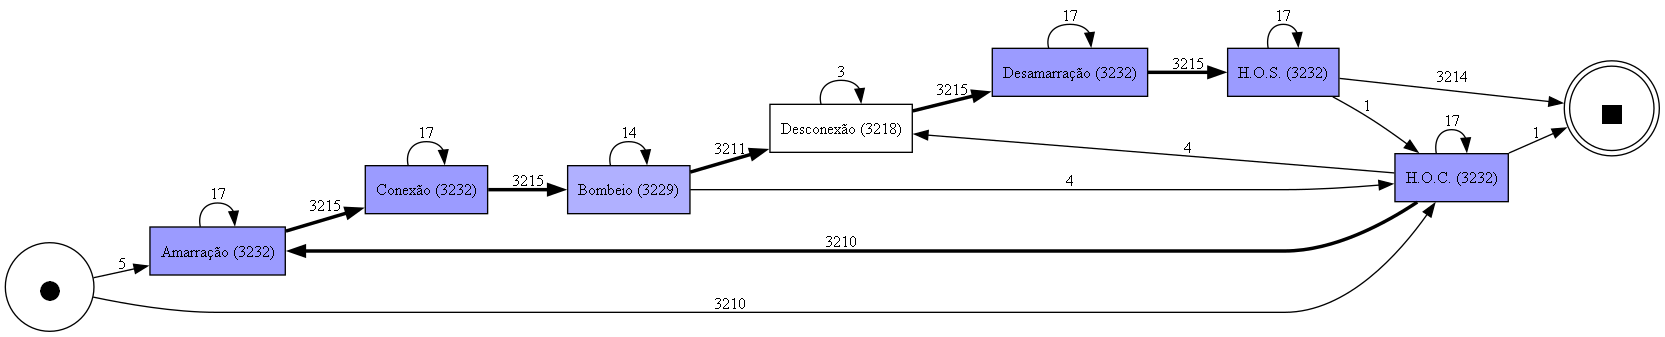

In [168]:
if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos
    log = pd.read_excel('Arquivos\\base_final.xlsx')

    #Descobre o grafo de fluxo direcionado (DFG) e as atividades iniciais e finais.
    #O DFG mostra a relação entre as atividades no log de eventos.
    log['ID'] = log['ID'].astype(str)
    dfg, start_activities, end_activities = pm4py.discover_dfg(log,case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')
    
    #Exibe o grafo de fluxo direcionado (DFG) juntamente com as atividades iniciais e finais.
    #Isso permite visualizar a sequência de atividades no log de eventos.
    pm4py.view_dfg(dfg, start_activities, end_activities)

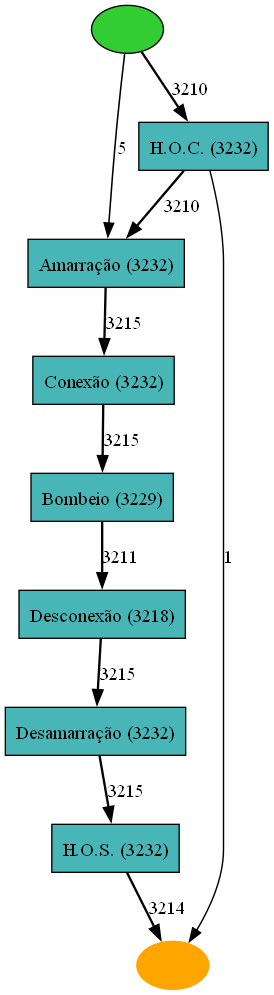

In [169]:
if __name__ == "__main__":
    # Lê o arquivo xlsx que contém o log de eventos
    log = pd.read_excel('Arquivos\\base_final.xlsx')

    # Descobre a rede heurística a partir do log de eventos.
    # A rede heurística é uma representação gráfica de relações entre atividades comuns no log.
    log['ID'] = log['ID'].astype(str)
    heuristics_net = pm4py.discover_heuristics_net(log, case_id_key='ID',activity_key='Ocorrência', timestamp_key='Início')

    # Exibe a rede heurística.
    # Isso permite visualizar as relações entre atividades no log de eventos.
    pm4py.view_heuristics_net(heuristics_net)

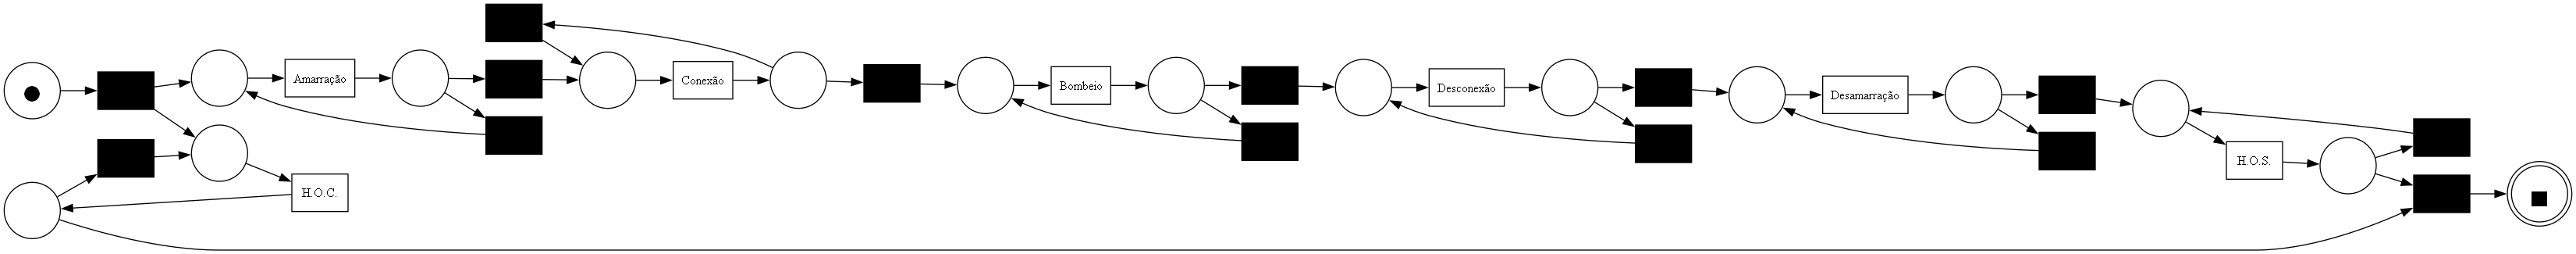

In [170]:
if __name__ == "__main__":
    #Lê o arquivo XES que contém o log de eventos.
    log = pd.read_excel('Arquivos\\base_final.xlsx')

    #Constrói a rede de Petri a partir do log de eventos.
    #A rede de Petri é uma representação gráfica de um sistema de transição de estados.
    log['ID'] = log['ID'].astype(str)
    petri_net, initial_marking, final_marking = pm4py.discover_petri_net_inductive(log,case_id_key='ID', activity_key='Ocorrência', timestamp_key='Início')

    #Exibe a rede de Petri.
    #Isso permite visualizar a estrutura da rede de Petri construída a partir dos dados do log.
    pm4py.view_petri_net(petri_net, initial_marking, final_marking)